# 002: Describe and understand dataset

In [36]:
from collections import Counter
import sys

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter, MaxNLocator
from matplotlib.patches import Patch
import seaborn as sns

sys.path.append("../")
import helpers
from preprocessing import preprocess, impute_missing_values
from visualizations import plot_class_distribution_by_group

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
x_train, x_test, y_train, train_ids, test_ids = helpers.load_csv_data("../data/dataset")

# Target description

In [ ]:
print(f"y_train.shape: {y_train.shape}")
print(f"The target contains these values: {np.unique(y_train)}")
unique, counts = np.unique(y_train, return_counts=True)
percentages = counts / counts.sum() * 100
for label, pct in zip(unique, percentages):
    print(f"Label {label}: {pct:.2f}%")

y_train.shape: (328135,)
The target contains these values: [-1  1]
Label -1: 91.17%
Label 1: 8.83%


# Feature description

x_train.shape: (328135, 321)
x_test.shape: (109379, 321)
Features with missing values: 239 / 321 (74.5%)
Featurs with more than 90\% missing data: 30.8


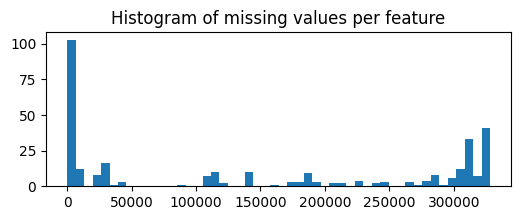

In [ ]:
print(f"x_train.shape: {x_train.shape}")
print(f"x_test.shape: {x_test.shape}")
missing_values = (np.isnan(x_train).mean(axis=0))
print(f"Features with missing values: {(missing_values>0).sum()} / {x_train.shape[1]} ({(missing_values > 0.00).mean()*100:.1f}%)")
print(f"Features with more than 90% missing data: {(missing_values > 0.9).mean()*100:.1f}")
print(f"Recalculated features: {np.sum(['_' in name for name in feature_names])}")

In [39]:
# Export feature names for reference and use in dataset preprocessing
with open("../data/dataset/x_train.csv", "r") as f:
    feature_names = f.readline().strip().split(",")
with open("../data/feature_names.csv", "w") as out_f:
    for name in feature_names:
        out_f.write(f"{name}\n")

In [8]:
# Calculate percentage of missing data for each feature (excluding the ID column)
missing_percentages = np.isnan(x_train).sum(axis=0) / x_train.shape[0] * 100

with open("../data/missing_percentages.csv", "w") as out_f:
    for name, pct in zip(feature_names, missing_percentages):
        out_f.write(f"{pct:.1f}\n")

# Feature visualization

In [5]:
x_train, _, y_train, _ = preprocess(one_hot_encoding=False) # replace missing values with NaN

Loading raw data...
Replacing missing value codes with np.nan...


In [6]:
# Missingness
missing_perc = np.isnan(x_train).mean(axis=0)
sorted_missing = missing_perc[np.argsort(missing_perc)]

In [12]:
# Explained Variance
X = impute_missing_values(x_train, x_train) # PCA needs complete data
mean = X.mean(axis=0)
std = X.std(axis=0)
X[:,std>0] = (X[:,std>0] - mean[std>0]) / std[std>0]
X_centered = X - np.mean(X, axis=0)
cov_matrix = np.cov(X_centered, rowvar=False)  # shape (n_features, n_features)
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
cumulative_variance = np.cumsum(explained_variance_ratio)

In [20]:
print(f"Number of components without added variance: {np.sum(cumulative_variance > 1-1e-16)}")

Number of components without added variance: 19


In [24]:
# Variable types
# Number of unique values per feature and variable types
variable_type = []
with open("../data/variable_type.txt", "r") as f:
    for line in f:
        line = line.strip().strip('"')  # remove whitespace and surrounding quotes
        # split by comma and convert to int
        if line == "":
            variable_type.append([])
        else:
            variable_type.append(line)
num_unique = []
for i in range(x_train.shape[1]):  # Skip ID column
        col = x_train[:, i] # skip ID column
        unique_vals = np.unique(col[~np.isnan(col)])
        n_unique = len(unique_vals)
        num_unique.append(n_unique)

unique_types = ["binary","nominal","ordinal","continuous"]  # preserve order
# Map variable_type strings to numeric codes following unique_types order
type_to_idx = {t: i for i, t in enumerate(unique_types)}
variable_idx = np.array([type_to_idx.get(t, len(unique_types)) for t in variable_type])

# Ensure num_unique is an array for lexsort
num_unique = np.array(num_unique)
order = np.lexsort((num_unique, variable_idx))
sorted_unique_vals = np.array(num_unique)[order]
sorted_var_types = np.array(variable_type)[order]
type_counts = Counter(sorted_var_types)

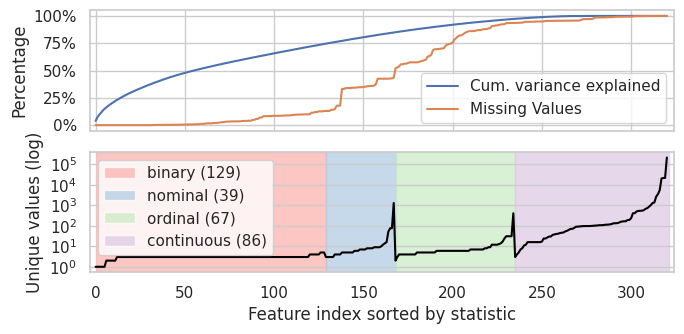

In [35]:
sns.set(style="whitegrid")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 3.5), sharex=True)

# --- Subplot 1: cumulative variance & missing values (percentage) ---
sns.lineplot(x=range(len(cumulative_variance)), y=cumulative_variance, ax=ax1, label="Cum. variance explained")
sns.lineplot(x=range(len(sorted_missing)), y=sorted_missing, ax=ax1, label="Missing Values")

ax1.set_ylabel("Percentage")
ax1.yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax1.legend(loc="lower right")
ax1.yaxis.set_major_locator(MaxNLocator(nbins=5))

# --- Subplot 2: unique values (log scale) ---
sns.lineplot(x=range(len(sorted_unique_vals)), y=sorted_unique_vals, ax=ax2, color="black", label="# Unique values")

ax2.set_ylabel("")
yticks = np.logspace(
    np.log10(1),
    np.log10(100000),
    6
)
ax2.set_yscale("log")
ax2.set_yticks(yticks)

colors = plt.cm.Pastel1.colors  # use soft, distinct colors
color_map = {t: colors[i % len(colors)] for i, t in enumerate(unique_types)}

for i, t in enumerate(sorted_var_types):
    if i == 0 or sorted_var_types[i] != sorted_var_types[i - 1]:
        start = i
        # Find where this region ends
        end = next((j for j in range(i + 1, len(sorted_var_types)) if sorted_var_types[j] != t), len(sorted_var_types))
        ax2.axvspan(start, end, color=color_map[t], alpha=0.75, zorder=0)
        
ax2.set_xlabel("Feature index sorted by statistic")
ax2.set_ylabel("Unique values (log)")
patches = [Patch(facecolor=color_map[t], alpha=0.75, label=f"{t} ({type_counts[t]})") for t in unique_types]
#line_handles, _ = ax2.get_legend_handles_labels())
ax2.legend(handles=patches, loc="upper left", frameon=True)

ax2.grid(axis='x')
plt.xlim(-3, x_train.shape[1]+3)
plt.tight_layout()
plt.savefig("../results/feature_statistics_overview.pdf")
plt.show()


In [37]:
def plot_class_distribution_by_group(y, group_attr, annotate=True):
    mask = ~np.isnan(group_attr)
    group_clean = group_attr[mask]
    y_clean = y[mask]

    # Compute proportions per group
    unique_groups = np.unique(group_clean)
    proportions = []
    for g in unique_groups:
        vals = y_clean[group_clean == g]
        pos_ratio = np.mean(vals == 1)
        proportions.append(pos_ratio)
    proportions = np.array(proportions)
    # Create a color map based on the relation (-1 ↔ 1)
    cmap = plt.cm.seismic
    vmin, vmax = proportions.min(), proportions.max()
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    colors = [cmap(norm(p)) for p in proportions]

    # Plot one bar per group, colored by ratio
    bars = plt.bar(unique_groups, [1]*len(unique_groups), color=colors)

    if annotate:
        for i, p in enumerate(proportions):
            plt.text(unique_groups[i], 0.5, f"{p*100:.0f}%", 
                     ha='center', va='center', color='black', fontsize=9)

    plt.title("Class Relation (-1 vs 1) by Group")
    plt.xlabel("Group")
    plt.ylabel("Relation (color-coded)")
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.ax.set_ylabel("Proportion of +1")
    cbar.set_ticks([0, 0.5, 1])
    cbar.set_ticklabels([f"{vmin:.2f}", f"{(vmin+vmax)/2:.2f}", f"{vmax:.2f}"])
    plt.show()

0 _STATE


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

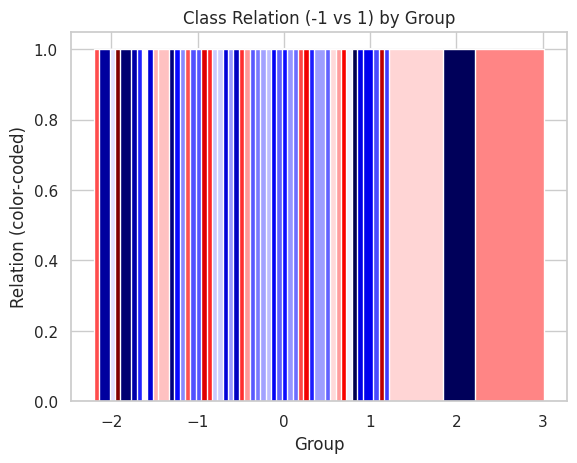

In [40]:
for i, feature_name in enumerate(feature_names[1:21]):  # Skip ID column
    print(i, feature_name)
    plot_class_distribution_by_group(y_train, x_train[:,i], annotate=False)
    plt.show()